In [239]:
# import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series
from io import StringIO
import math
import gc
from scipy import linalg
from scipy.optimize import minimize

In [4]:
class process_hyperspec(object):
    
    def __init__(self, path, scat):
        self.path = path
        self.scat = scat
        
    def read_data(self):
        ## Read data from txt
        data=pd.read_fwf(self.path, dtype = object, header = None)## Read data as Pandas DataFrame
        data_8 = data.loc[8,:].str[6:] ## Select data of column of wavelengths

        data_nm_dataframe =pd.read_csv(StringIO(data_8[0]))

        with open(self.path,'r',encoding='utf-8') as f:
            content = f.read()

        flag = 0
        for index in range(len(content)):##find the start point  of time and intensity data, pointer is the 'index'
            if (content[index] == '\n') and (flag != 9):
                flag = flag + 1
            elif (content[index] == '\n') and (flag == 9):
                break
            else:
                continue

        data_ns = pd.read_csv(StringIO(content[index:len(content)]), names = data_nm_dataframe.columns[0:len(set(data_nm_dataframe))]) ## Read data of time and gray 
        img_nm_ns = np.array(data_ns)    ## Transform to numpy array                                image as DataFrame; names is a 640x0 array indicates the wavelengths range
        
        self.data_frame = data_ns
        self.data_array = img_nm_ns
        
    def cal_846nm(self):
        time_total, wavelength_total = self.data_array.shape ## Generate an array contains intensity versus time data on 846nm
        data_846nm = np.zeros((time_total,), dtype = float )
        for i in range(wavelength_total):
            data_846nm = self.data_array[:,i] + data_846nm

        return data_846nm/wavelength_total
    
    def return_dataframe(self):
        
        return self.data_frame
    
    def return_array(self):
        return self.data_array

In [5]:
def name_g(i):
    if(i<=4 and i>=0):
        return  '0'+str(2*i+1)
    elif(i>4):
        return str(2*i+1)
    else:
        return None
    

dict1 = {i:'t5ns_scat'+ name_g(i) +'_abs_00.txt' for i in range(0, 8)}
dict1[-1] = 'ref_real_5ns.txt'


# print(dict1)

scat = [None]*9
data_480multi9 = np.zeros((9,480), dtype = float)
for i in range(0,9):
    scat[i] = process_hyperspec(dict1[i-1], i)
    scat[i].read_data()
    data_480multi9[i,:] = scat[i].cal_846nm()

# time_index = scat[0].return_dataframe().index
# plt.figure('ns/nm')
# for i in range(0,9):
#     plt.plot(data_480multi9[i,:])
    
# plt.show()
del scat, dict1, name_g, process_hyperspec
gc.collect()

10

In [6]:
def smooth(y, box_pts):
    box = np.ones(box_pts) / box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



def split_signal(y):
    THRESHOLD_V = 0.02
    for i in range(len(y)):
        if y[i] > THRESHOLD_V and y[i-1] <= THRESHOLD_V:
            index1  = i
        elif y[i] < THRESHOLD_V and y[i-1] >= THRESHOLD_V:
            index2 = i
    y2 = np.zeros((index2 - index1 + 1,))
    y2 = y[index1:index2]
        
    return y2, index1

#Generate h,y(x*h = y)
#===================================================================================================
# data_intensity_extended = np.zeros((9, 959), dtype = float)
data_intensity_extended = np.zeros((9, 959), dtype = float)
data_intensity_extended[:, 0:479]  = data_480multi9[:,0:479]
MAX = np.max(data_480multi9)
# h = smooth(data_480multi9[0,:]/max(data_480multi9[0,:]), 10) #ft*gt = qt ; ft.shape = (480,) gt.shape = (480,) qt.shape = (959,)
x = smooth(data_480multi9[0,:]/MAX, 10)

y =np.zeros((9,959))
for i in range(0,9):
    y[i,:] = smooth(data_intensity_extended[i,:]/MAX, 10)
    
#======================================================================================================

In [39]:
# M = 25
# a = 0.01
# LENGTH = 480
# eye = np.eye(M+1)
# L = np.zeros((M+1, LENGTH))
# t = np.arange(LENGTH)
# for j in range(M+1):
#     L[j,:] = np.polynomial.laguerre.Laguerre(coef = eye[j,:], domain = [0,LENGTH-1], window = [0,(LENGTH-1)*a])(t)
    

In [192]:
M = 50
a = 0.01
LENGTH = 480
L = np.zeros((M+1, LENGTH))
# TIME = np.arange(LENGTH)
alfa = 8
for t in range(LENGTH):
    L[0, t] = 1
    L[1, t] = 1 + alfa - t*a

for j in range(2,M+1):
    for t in range(LENGTH):
        L[j,t] = ((2*j - 1 + alfa - t*a)*L[j-1,t] - (j - 1 + alfa)*L[j-2,t])/(j)

In [195]:
Ln = M + 1
v = np.zeros((959, Ln))
for i in range(Ln):
    v[:, i] = np.convolve(x, L[i,:])

k = 1
c = np.linalg.lstsq(v, y[k,:], rcond=None)[0]

# h = np.polynomial.laguerre.Laguerre(coef = c, domain = [0,LENGTH-1], window = [0,(LENGTH-1)*a])(t)

# print(c)

[-1.03567759e-01 -3.97750577e-01 -7.76117954e-01 -9.69648435e-01
 -7.68988469e-01 -2.17231066e-01  3.97214573e-01  7.32010740e-01
  6.14203965e-01  1.41647274e-01 -3.89944875e-01 -6.71413915e-01
 -5.56041143e-01 -1.28530696e-01  3.59150909e-01  6.36337755e-01
  5.59724437e-01  1.81372541e-01 -2.89252645e-01 -6.01524123e-01
 -5.94363907e-01 -2.75575715e-01  1.86684712e-01  5.52396213e-01
  6.32208543e-01  3.83292667e-01 -6.82324753e-02 -4.89522991e-01
 -6.58381823e-01 -4.78854846e-01 -3.68237336e-02  4.36198436e-01
  6.79047601e-01  5.42814794e-01  8.50574497e-02 -4.41939571e-01
 -7.18647319e-01 -5.47255118e-01  6.62693549e-04  5.82508320e-01
  7.72086719e-01  3.64251500e-01 -3.92345333e-01 -8.63093018e-01
 -4.99733336e-01  5.02262318e-01  1.00107019e+00 -4.03922572e-02
 -1.32158680e+00  9.04276862e-01 -1.82194974e-01]


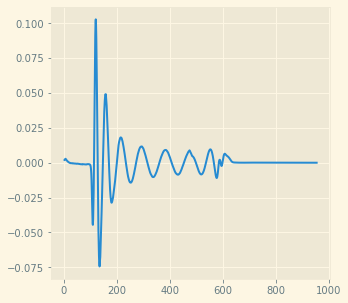

In [198]:
h2 = c.dot(L)

plt.figure(figsize = (5, 5))
# plt.style.use('dark_background')
plt.style.use('Solarize_Light2')
plt.plot(y[k,:] - np.convolve(x, h2))
plt.show()

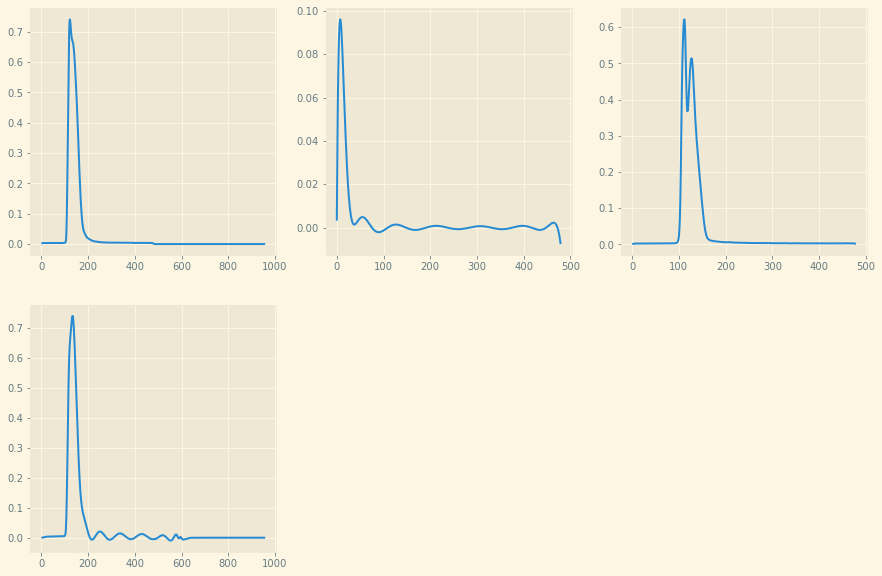

In [197]:
plt.figure(figsize = (15, 10))
# plt.style.use('dark_background')
plt.style.use('Solarize_Light2')
plt.subplot(2,3,1)
# plt.plot(np.convolve(h, x))
plt.plot(y[k,:])
plt.subplot(2,3,2)
plt.plot(h2)
plt.subplot(2,3,3)
plt.plot(x)
plt.subplot(2,3,4)
plt.plot(np.convolve(x, h2))
plt.show()

In [199]:
epsilon = y[k,:] - np.convolve(x, h2)
F = epsilon.T.dot(epsilon)

In [200]:
F

0.191166176499185

In [270]:
class deconv(object):
    
    def __init__(self, x, y ,M , k):
        self.x = x
        self.y = y
        self.M = M
        self.k = k
        
    def cal_error(self, z):
        M = self.M
        x = self.x
        y = self.y
        k = self.k
        
        a = z[0]
        alfa = z[1]
        # a = 0.01
        
        LENGTH = 480
        L = np.zeros((M+1, LENGTH))
        # TIME = np.arange(LENGTH)
        # alfa = 8
        for t in range(LENGTH):
            L[0, t] = 1
            L[1, t] = 1 + alfa - t*a

        for j in range(2,M+1):
            for t in range(LENGTH):
                L[j,t] = ((2*j - 1 + alfa - t*a)*L[j-1,t] - (j - 1 + alfa)*L[j-2,t])/(j)
        
        # print(L)
        Ln = M + 1
        v = np.zeros((959, Ln))
        for i in range(Ln):
            v[:, i] = np.convolve(x, L[i,:])

        # k = 1
        c = np.linalg.lstsq(v, y[k,:], rcond=None)[0]

        # h = np.polynomial.laguerre.Laguerre(coef = c, domain = [0,LENGTH-1], window = [0,(LENGTH-1)*a])(t)

        # print(c)
        h2 = c.dot(L)
        self.h = h2
        epsilon = y[k,:] - np.convolve(x, h2)
        F = epsilon.T.dot(epsilon)
        
        return F
        
    def give_h(self):
            return(self.h)
    

In [233]:
s0 = deconv(x,y,50)
# a = 0.01
a = 1
alfa = 5
for i in range(10):
    dFda = (s0.cal_error(a+0.00001,alfa) - s0.cal_error(a,alfa))/0.00001
    dFdalfa = (s0.cal_error(a,alfa+0.00001) - s0.cal_error(a,alfa))/0.00001
    a = a - 0.1*dFda
    alfa = alfa - 0.1*dFdalfa
    

In [234]:
print(a,alfa)

1.0000037856295876 4.999999931787897


In [271]:
s0 = deconv(x,y,50,7)
z = minimize(s0.cal_error, x0 = [0.01, 8], method  = 'Nelder-Mead', options={"xtol" : 1e-20, "disp":True}).x

Optimization terminated successfully.
         Current function value: 0.000031
         Iterations: 151
         Function evaluations: 353


In [272]:
# s0 = deconv(x,y,50,7)
s0.cal_error(z)
h = s0.give_h()

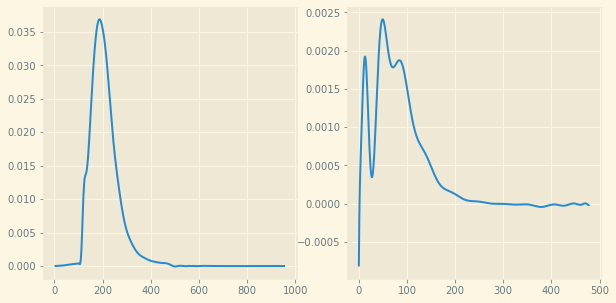

In [273]:
plt.figure(figsize = (10, 5))
# plt.style.use('dark_background')
plt.style.use('Solarize_Light2')
plt.subplot(1,2,1)
plt.plot(np.convolve(x, h))
plt.subplot(1,2,2)
plt.plot(h)
plt.show()